# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [ ]:
# installation of sklearn_crfsuite
#!pip install sklearn_crfsuite==0.5.0

In [ ]:
#!pip install -U spacy

   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   --------------- ------------------------ 5.5/13.9 MB 27.9 MB/s eta 0:00:01
   ----------------------------------- ---- 12.3/13.9 MB 29.7 MB/s eta 0:00:01
   ---------------------------------------- 13.9/13.9 MB 23.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/632.6 kB ? eta -:--:--
   --------------------------------------- 632.6/632.6 kB 12.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 19.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
   ------------------- -------------------- 6.3/12.7 MB 32.1 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.7 MB 31.5 MB/s eta 0:00:01
   ---------------------------------------- 12.7/12.7 MB 24.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   -------------------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.3.1 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.1 which is incompatible.


#### **1.2** Import necessary libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [3]:
# define a function to load json file to a dataframe
def load_json_dataframe(json_path):
    """
    Load the ingredient and quantity data from a JSON file and return a pandas DataFrame.
    Returns:
        pd.DataFrame: DataFrame containing the input and pos tag columns.
    """
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Convert list of dicts into DataFrame
    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [4]:
# read the json file by giving the file path and create a dataframe
df = load_json_dataframe("ingredient_and_quantity.json")
print(df)

                                                 input  \
0    6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 ...   
1    2-1/2 cups rice cooked 3 tomatoes teaspoons BC...   
2    1-1/2 cups Rice Vermicelli Noodles Thin 1 Onio...   
3    500 grams Chicken 2 Onion chopped 1 Tomato 4 G...   
4    1 tablespoon chana dal white urad 2 red chilli...   
..                                                 ...   
280  2 Mooli Mullangi Radish 200 grams Paneer Homem...   
281  2 cups Fresh orange juice teaspoons Ginger gra...   
282  3 Potatoes Aloo 2 Green zucchini 1 tablespoon ...   
283  1 cup Pink Masoor Dal 200 grams Drumstick Leav...   
284  1/2 cup Bajra Flour Jowar Whole Wheat 2 cups M...   

                                                   pos  
0    quantity ingredient ingredient ingredient ingr...  
1    quantity unit ingredient ingredient quantity i...  
2    quantity unit ingredient ingredient ingredient...  
3    quantity unit ingredient quantity ingredient i...  
4    quantity unit

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [6]:
# display first five rows of the dataframe - df
df.head(5)

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 ...,quantity ingredient ingredient ingredient ingr...
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC...,quantity unit ingredient ingredient quantity i...
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onio...,quantity unit ingredient ingredient ingredient...
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 G...,quantity unit ingredient quantity ingredient i...
4,1 tablespoon chana dal white urad 2 red chilli...,quantity unit ingredient ingredient ingredient...


In [8]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [11]:
# print the information of the dataframe
df.describe()

,input,pos
count,285,285
unique,285,284
top,1/2 cup Bajra Flour Jowar Whole Wheat 2 cups M...,quantity ingredient ingredient ingredient ingr...
freq,1,2


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [12]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS
# Split 'input' and 'pos' strings into lists of tokens
df['input_tokens'] = df['input'].apply(lambda x: x.split())
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [13]:
# display first five rows of the dataframe - df
df.head(5)

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 ...,quantity ingredient ingredient ingredient ingr...,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, ...","[quantity, ingredient, ingredient, ingredient,..."
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC...,quantity unit ingredient ingredient quantity i...,"[2-1/2, cups, rice, cooked, 3, tomatoes, teasp...","[quantity, unit, ingredient, ingredient, quant..."
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onio...,quantity unit ingredient ingredient ingredient...,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin,...","[quantity, unit, ingredient, ingredient, ingre..."
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 G...,quantity unit ingredient quantity ingredient i...,"[500, grams, Chicken, 2, Onion, chopped, 1, To...","[quantity, unit, ingredient, quantity, ingredi..."
4,1 tablespoon chana dal white urad 2 red chilli...,quantity unit ingredient ingredient ingredient...,"[1, tablespoon, chana, dal, white, urad, 2, re...","[quantity, unit, ingredient, ingredient, ingre..."


##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [14]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
# Add lengths
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [15]:
# check for the equality of input_length and pos_length in the dataframe
# Check where lengths mismatch
mismatch_rows = df[df['input_length'] != df['pos_length']]
print("\n Rows with unequal number of input and pos tokens:")
print(mismatch_rows[['input', 'pos', 'input_length', 'pos_length']])


 Rows with unequal number of input and pos tokens:
                                                 input  \
17   2 cups curd 1 cup gourd cucumber green cor cor...   
27   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 ...   
79   1/2 cup Poha Flattened rice 2 tablespoons Rice...   
164  1/2 cup All Purpose Flour Maida Whole Wheat 1/...   
207  1 cup Cashew nuts Badam Almond 1 1/4 cups Suga...   

                                                   pos  input_length  \
17   quantity unit ingredient quantity unit ingredi...            15   
27   quantity ingredient ingredient quantity unit i...            37   
79   quantity unit ingredient ingredient ingredient...            38   
164  quantity unit ingredient ingredient ingredient...            54   
207  quantity unit ingredient ingredient ingredient...            18   

     pos_length  
17           14  
27           36  
79           37  
164          53  
207          17  


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [16]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    """
    Return a set of unique NER labels (POS tags) from the dataframe.
    Returns:
        Set[str]: A set of unique POS labels across the dataset.
    """
    # Flatten all pos_tokens into one list
    all_labels = [label for sublist in df['pos_tokens'] for label in sublist]
    
    # Return unique labels
    return set(all_labels)

# Get unique labels
labels = unique_labels(df)
print(" Unique POS/NER Labels found in dataset:", labels)

 Unique POS/NER Labels found in dataset: {'quantity', 'unit', 'ingredient'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [17]:
# drop the irrelevant recipe data
# # Drop invalid rows
df = df[df['input_length'] == df['pos_length']].reset_index(drop=True)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [18]:
# update the input and pos length in input_length and pos_length
# Recalculate lengths after dropping
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [19]:
# validate the input length and pos length as input_length and pos_length
is_valid = (df['input_length'] == df['pos_length']).all()
print(f"\n Validation after cleanup: All rows have matching input and pos lengths: {is_valid}")




 Validation after cleanup: All rows have matching input and pos lengths: True


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [20]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [21]:
# print the first five rows of train_df
train_df.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length
175,250 grams Okra Oil 1 Onion finely chopped Toma...,quantity unit ingredient ingredient quantity i...,"[250, grams, Okra, Oil, 1, Onion, finely, chop...","[quantity, unit, ingredient, ingredient, quant...",31,31
55,200 grams Paneer Homemade Cottage Cheese 2 Pot...,quantity unit ingredient ingredient ingredient...,"[200, grams, Paneer, Homemade, Cottage, Cheese...","[quantity, unit, ingredient, ingredient, ingre...",41,41
109,500 grams Cabbage Patta Gobi Muttaikose 1 teas...,quantity unit ingredient ingredient ingredient...,"[500, grams, Cabbage, Patta, Gobi, Muttaikose,...","[quantity, unit, ingredient, ingredient, ingre...",25,25
213,500 grams Fresh Figs 1/4 cup Lemon juice 1 tea...,quantity unit ingredient ingredient quantity u...,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, jui...","[quantity, unit, ingredient, ingredient, quant...",21,21
38,2 cups Water 1 teaspoon Tea leaves 1/4 Milk 10...,quantity unit ingredient quantity unit ingredi...,"[2, cups, Water, 1, teaspoon, Tea, leaves, 1/4...","[quantity, unit, ingredient, quantity, unit, i...",12,12


In [22]:
# print the first five rows of the val_df
val_df.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length
33,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Gh...,quantity unit ingredient quantity unit ingredi...,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tabl...","[quantity, unit, ingredient, quantity, unit, i...",15,15
108,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups...,quantity ingredient ingredient ingredient quan...,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo...","[quantity, ingredient, ingredient, ingredient,...",56,56
240,1 tablespoon Sunflower Oil 3 Potato Aloo Ginge...,quantity unit ingredient ingredient quantity i...,"[1, tablespoon, Sunflower, Oil, 3, Potato, Alo...","[quantity, unit, ingredient, ingredient, quant...",35,35
259,1 cup green peas gram flour 1/2 cheese tsp gin...,quantity unit ingredient ingredient ingredient...,"[1, cup, green, peas, gram, flour, 1/2, cheese...","[quantity, unit, ingredient, ingredient, ingre...",18,18
154,2 cups Brown Rice cooked tablespoons Garlic ch...,quantity unit ingredient ingredient ingredient...,"[2, cups, Brown, Rice, cooked, tablespoons, Ga...","[quantity, unit, ingredient, ingredient, ingre...",51,51


###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [23]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [24]:
# validate the shape of training and validation samples
print(f"  X_train length: {len(X_train)}")
print(f"  X_val   length: {len(X_val)}")
print(f"  y_train length: {len(y_train)}")
print(f"  y_val   length: {len(y_val)}")

  X_train length: 196
  X_val   length: 84
  y_train length: 196
  y_val   length: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [25]:
# Display the number of unique labels present in y_train
unique_labels_train = set(label for seq in y_train for label in seq)
print(f" Number of unique labels in y_train: {len(unique_labels_train)}")
print(f" Unique labels: {unique_labels_train}")

 Number of unique labels in y_train: 3
 Unique labels: {'quantity', 'ingredient', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [26]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flattens a nested list (list of lists) into a single list.
    Returns:
        List[Any]: A single flattened list.
    """
    return [item for sublist in nested_list for item in sublist]

In [42]:
# initialise the dataset_name
dataset_name = 'Training'
flat_X_train = flatten_list(X_train)
flat_y_train = flatten_list(y_train)

print(f" Flattened '{dataset_name}' dataset:")
print(f" Total tokens  : {len(flat_X_train)}")
print(f" Total labels  : {len(flat_y_train)}")
print( flat_X_train)

 Flattened 'Training' dataset:
 Total tokens  : 7114
 Total labels  : 7114
['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric', '200', 'grams', 'Paneer', 'Homemade', 'Cottage', 'Cheese', '2', 'Potato', 'Aloo', 'Bay', 'leaf', 'tej', 'patta', 'Dry', 'Red', 'Chilli', '1', 'tablespoon', 'Panch', 'Phoran', 'Masala', 'roasted', 'and', 'powdered', 'Tomato', 'big', 'sized', 'teaspoon', 'Turmeric', 'powder', 'Haldi', 'Cumin', 'seeds', 'Jeera', 'Ginger', 'grated', 'Salt', '1/2', 'Sugar', 'Sunflower', 'Oil', '500', 'grams', 'Cabbage', 'Patta', 'Gobi', 'Muttaikose', '1', 'teaspoon', 'Mustard', 'seeds', '1-1/2', 'White', 'Urad', 'Dal', 'Split', 'sprig', 'Curry', 'leaves', 'Green', 'Chilli', '1/4', 'cup', 'Fresh', 'coconut', 'Salt', '500', 'grams', 'Fresh', 'Figs',

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [28]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(dataframe, dataset_name="Dataset"):
    """
    Validates and displays input_tokens and pos_tokens from the given dataframe.
    Returns:
        None
    """
    print(f"\n Validating {dataset_name} Dataset")

    # Check length equality for each row
    length_mismatches = dataframe[
        dataframe['input_tokens'].apply(len) != dataframe['pos_tokens'].apply(len)
    ]

    if length_mismatches.empty:
        print(f" All rows in {dataset_name} dataset have matching input and pos token lengths.")
    else:
        print(f" Found {len(length_mismatches)} rows with mismatched lengths in {dataset_name} dataset.")
        print(length_mismatches[['input_tokens', 'pos_tokens']])

    # Display first 10 records
    print(f"\n First 10 input_tokens in {dataset_name} dataset:")
    print(dataframe['input_tokens'].head(10).to_list())

    print(f"\n First 10 pos_tokens in {dataset_name} dataset:")
    print(dataframe['pos_tokens'].head(10).to_list())

In [29]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_df, "Training")


 Validating Training Dataset
 All rows in Training dataset have matching input and pos token lengths.

 First 10 input_tokens in Training dataset:
[['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric'], ['200', 'grams', 'Paneer', 'Homemade', 'Cottage', 'Cheese', '2', 'Potato', 'Aloo', 'Bay', 'leaf', 'tej', 'patta', 'Dry', 'Red', 'Chilli', '1', 'tablespoon', 'Panch', 'Phoran', 'Masala', 'roasted', 'and', 'powdered', 'Tomato', 'big', 'sized', 'teaspoon', 'Turmeric', 'powder', 'Haldi', 'Cumin', 'seeds', 'Jeera', 'Ginger', 'grated', 'Salt', '1/2', 'Sugar', 'Sunflower', 'Oil'], ['500', 'grams', 'Cabbage', 'Patta', 'Gobi', 'Muttaikose', '1', 'teaspoon', 'Mustard', 'seeds', '1-1/2', 'White', 'Urad', 'Dal', 'Split', 'sprig', 'Curry', 'leaves', 'Green', 'Chill

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [30]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, labels):
    """
    Categorizes tokens into ingredients, units, and quantities based on corresponding labels.

    Args:
        tokens (List[str]): flattened list of input tokens (words).
        labels (List[str]): The corresponding NER labels for each token.

    Returns:
        Tuple[List[str], List[str], List[str]]: Lists of ingredients, units, and quantities.
    """
    ingredients = []
    units = []
    quantities = []

    for token, label in zip(tokens, labels):
        if label == "ingredient":
            ingredients.append(token)
        elif label == "unit":
            units.append(token)
        elif label == "quantity":
            quantities.append(token)

    return ingredients, units, quantities

In [31]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(flat_X_train, flat_y_train)

print(" Ingredients:", ingredients)
print("\n Units:", units)
print("\n Quantities:", quantities)

 Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely', 'Cumin', 'seeds', 'asafoetida', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric', 'Paneer', 'Homemade', 'Cottage', 'Cheese', 'Potato', 'Aloo', 'Bay', 'leaf', 'tej', 'patta', 'Dry', 'Red', 'Chilli', 'Panch', 'Phoran', 'Masala', 'roasted', 'and', 'powdered', 'Tomato', 'big', 'sized', 'Turmeric', 'powder', 'Haldi', 'Cumin', 'seeds', 'Jeera', 'Ginger', 'grated', 'Salt', 'Sugar', 'Sunflower', 'Oil', 'Cabbage', 'Patta', 'Gobi', 'Muttaikose', 'Mustard', 'seeds', 'White', 'Urad', 'Dal', 'Split', 'Curry', 'leaves', 'Green', 'Chilli', 'Fresh', 'coconut', 'Salt', 'Fresh', 'Figs', 'Lemon', 'juice', 'zest', 'Red', 'Chilli', 'flakes', 'Honey', 'Brown', 'Sugar', '(Demerara', 'Sugar)', 'Water', 'Tea', 'leaves', 'Milk', 'Saffron', 'strands', 'Rice', 'Green', 'peas', 'Potatoes', 'Aloo', 'Onion', 'Ginger', 'Garlic', 'Paste', 'Chillies', 'Black', 'cardamo

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [32]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, item_type="Item"):
    """
    Displays the top 10 most frequent items from a given list.

    Args:
        item_list (List[str]): List of items (e.g., ingredients, units).
        item_type (str): Label for printing the item type (default is 'Item').

    Returns:
        List[Tuple[str, int]]: List of top 10 (item, count) tuples.
    """
    counter = Counter(item_list)
    top_items = counter.most_common(10)

    print(f"\n Top 10 most frequent {item_type.lower()}s:")
    for item, count in top_items:
        print(f"{item:>15}: {count}")

    return top_items

In [33]:
# get the top ingredients which are frequently seen in the recipe
get_top_frequent_items(ingredients, item_type="Ingredient")


 Top 10 most frequent ingredients:
         powder: 129
           Salt: 102
          seeds: 89
          Green: 85
        chopped: 84
            Oil: 83
            Red: 81
         Chilli: 77
      Coriander: 71
      Sunflower: 65


[('powder', 129),
 ('Salt', 102),
 ('seeds', 89),
 ('Green', 85),
 ('chopped', 84),
 ('Oil', 83),
 ('Red', 81),
 ('Chilli', 77),
 ('Coriander', 71),
 ('Sunflower', 65)]

In [34]:
# get the top units which are frequently seen in the recipe
get_top_frequent_items(units, item_type="Unit")


 Top 10 most frequent units:
       teaspoon: 162
            cup: 136
     tablespoon: 99
          grams: 63
    tablespoons: 61
           inch: 52
           cups: 50
          sprig: 41
         cloves: 39
      teaspoons: 39


[('teaspoon', 162),
 ('cup', 136),
 ('tablespoon', 99),
 ('grams', 63),
 ('tablespoons', 61),
 ('inch', 52),
 ('cups', 50),
 ('sprig', 41),
 ('cloves', 39),
 ('teaspoons', 39)]

#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [35]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(item_list, item_type="Item"):
    """
    Plots a bar graph of the top 10 most frequent items from the list.

    Args:
        item_list (List[str]): List of items (e.g., ingredients or units).
        item_type (str): Label for the item type (used in titles and axis labels).
    """
    counter = Counter(item_list)
    top_items = counter.most_common(10)

    labels, counts = zip(*top_items)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color='skyblue', edgecolor='black')
    plt.title(f"Top 10 Most Frequent {item_type}s in Training Data")
    plt.xlabel(f"{item_type}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Annotate bar values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



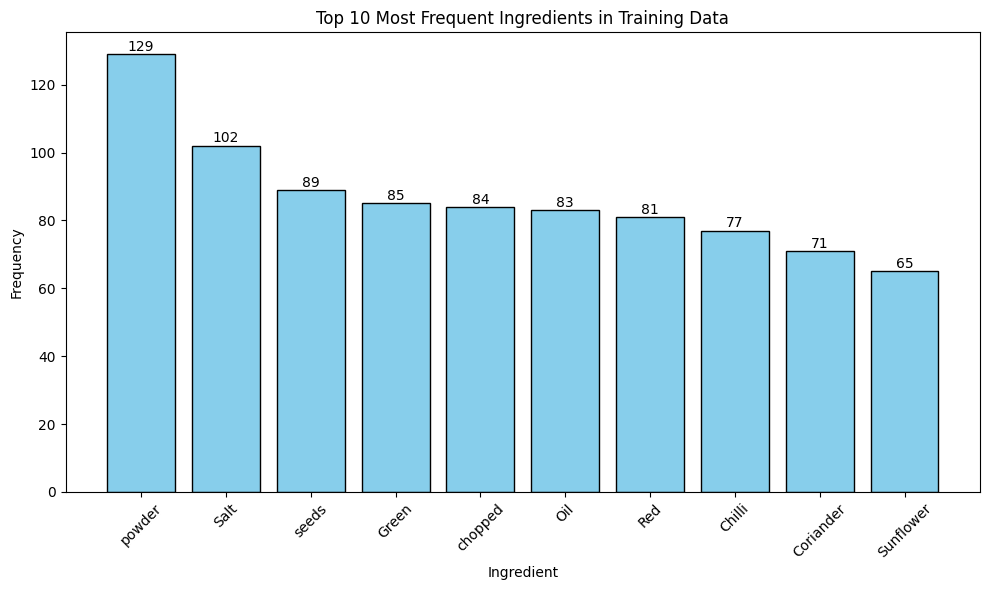

In [36]:
# plot the top frequent ingredients in training data
# Ingredients
plot_top_items(ingredients, item_type="Ingredient")



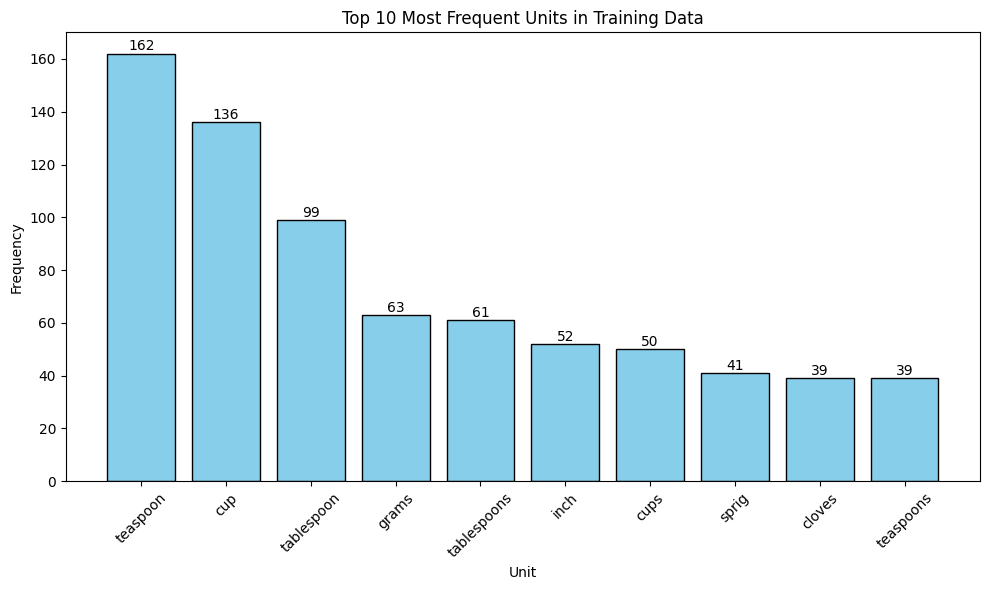

In [37]:
# plot the top frequent units in training data
plot_top_items(units, item_type="Unit")

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [43]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    "cup", "cups", "tsp", "teaspoon", "teaspoons", "tbsp", "tablespoon", "tablespoons",
    "ml", "l", "litre", "litres", "gram", "grams", "g", "kg", "kilogram", "kilograms",
    "oz", "ounce", "ounces", "pinch", "dash", "pound", "lb", "lbs", "packet", "packets"
}

quantity_keywords = {
    "half", "quarter", "third", "few", "some", "one", "two", "three", "four", "five",
    "six", "seven", "eight", "nine", "ten", "dozen", "dozens"
}

# Regex pattern to match integers, decimals, fractions (like 1/2, 2-1/2, ¾, etc.)
quantity_pattern = re.compile(
    r'(?:(?:\d+/\d+)|(?:\d+-\d+/\d+)|(?:\d+/\d+)|(?:\d+(?:\.\d+)?)|(?:\.\d+))'r'|(?:\d+)|(?:\w+)')  # Match whole numbers

In [45]:
# load spaCy model
nlp = spacy.load("en_core_web_sm") 

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [46]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sent, i):
    """
    Extracts features for a token in a sentence for CRF training.

    Args:
        sent (List[spacy.tokens.Token]): Tokenized sentence using spaCy.
        i (int): Index of the current token.

    Returns:
        dict: A dictionary of features for the token.
    """
    token = sent[i]
    features = {}

    # -------------------------------
    # Core Linguistic Features
    # -------------------------------
    features['bias'] = 1.0
    features['token'] = token.text.lower()
    features['lemma'] = token.lemma_.lower()
    features['pos_tag'] = token.pos_
    features['tag'] = token.tag_
    features['dep'] = token.dep_
    features['shape'] = token.shape_
    features['is_stop'] = token.is_stop
    features['is_digit'] = token.is_digit
    features['has_digit'] = any(char.isdigit() for char in token.text)
    features['has_alpha'] = any(char.isalpha() for char in token.text)
    features['hyphenated'] = '-' in token.text
    features['slash_present'] = '/' in token.text
    features['is_title'] = token.text.istitle()
    features['is_upper'] = token.text.isupper()
    features['is_punct'] = token.is_punct

    # -------------------------------
    # Quantity & Unit Detection
    # Improved Quantity & Unit Detection
    # -------------------------------
    token_lower = token.text.lower()
    features['is_quantity'] = bool(quantity_pattern.match(token.text)) or token_lower in quantity_keywords
    features['is_unit'] = token_lower in unit_keywords
    features['is_numeric'] = token.like_num
    features['is_fraction'] = '/' in token.text or '½' in token.text or '-' in token.text and any(char.isdigit() for char in token.text)
    features['is_decimal'] = '.' in token.text and any(char.isdigit() for char in token.text)
    features['preceding_word'] = sent[i-1].text if i > 0 else ""
    features['following_word'] = sent[i+1].text if i < len(sent)-1 else ""

    # -------------------------------
    # Contextual Features
    # -------------------------------
    if i > 0:
        prev_token = sent[i-1]
        prev_lower = prev_token.text.lower()
        features['prev_token'] = prev_lower
        features['prev_is_quantity'] = bool(quantity_pattern.match(prev_token.text)) or prev_lower in quantity_keywords
        features['prev_is_digit'] = prev_token.is_digit
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent) - 1:
        next_token = sent[i+1]
        next_lower = next_token.text.lower()
        features['next_token'] = next_lower
        features['next_is_unit'] = next_lower in unit_keywords
        features['next_is_ingredient'] = next_lower not in unit_keywords and next_lower not in quantity_keywords and not quantity_pattern.match(next_lower)
    else:
        features['EOS'] = True  # End of sentence

    return features
 # Process the entire sentence with spaCy
   



### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [47]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Generate feature dictionaries for each token in the given sentence.

    Args:
        sent (List[spacy.tokens.Token]): A tokenized sentence using spaCy.

    Returns:
        List[dict]: List of feature dictionaries, one per token.
    """
    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [48]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Generate feature sequences using sent2features
X_train_features = [sent2features(nlp(" ".join(tokens))) for tokens in X_train]
X_val_features   = [sent2features(nlp(" ".join(tokens))) for tokens in X_val]

# Generate label sequences directly from y_train and y_val
y_train_labels = y_train
y_val_labels = y_val

# Print Lengths
print("\n Dataset Summary:")
print(f"X_train_features length: {len(X_train_features)}")
print(f"y_train_labels   length: {len(y_train_labels)}")
print(f"X_val_features   length: {len(X_val_features)}")
print(f"y_val_labels     length: {len(y_val_labels)}")
print(X_train_features[0])  # Display first feature set for inspection


 Dataset Summary:
X_train_features length: 196
y_train_labels   length: 196
X_val_features   length: 84
y_val_labels     length: 84
[{'bias': 1.0, 'token': '250', 'lemma': '250', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'ddd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '', 'following_word': 'grams', 'BOS': True, 'next_token': 'grams', 'next_is_unit': True, 'next_is_ingredient': False}, {'bias': 1.0, 'token': 'grams', 'lemma': 'gram', 'pos_tag': 'NOUN', 'tag': 'NNS', 'dep': 'nsubj', 'shape': 'xxxx', 'is_stop': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': True, 'is_numer

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [ ]:
# Convert labels into list as y_train_labels and y_val_labels


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [63]:
# print the length of train features and labels
print("Training Data Stats:")
print(f"X_train_features length: {len(X_train_features)}")
print(f"y_train_labels   length: {len(y_train_labels)}")
print(X_train_features[0])

Training Data Stats:
X_train_features length: 196
y_train_labels   length: 196
[{'bias': 1.0, 'token': '250', 'lemma': '250', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'ddd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '', 'following_word': 'grams', 'BOS': True, 'next_token': 'grams', 'next_is_unit': True, 'next_is_ingredient': False}, {'bias': 1.0, 'token': 'grams', 'lemma': 'gram', 'pos_tag': 'NOUN', 'tag': 'NNS', 'dep': 'nsubj', 'shape': 'xxxx', 'is_stop': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': True, 'is_numeric': False, 'is_fraction': False, 'is_decimal': False,

In [50]:
# print the length of validation features and labels
print("Validation Data Stats:")
print(f"X_train_features length: {len(X_val_features)}")
print(f"y_train_labels   length: {len(y_val_labels)}")

Validation Data Stats:
X_train_features length: 84
y_train_labels   length: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [53]:
# Flatten labels in y_train
y_train_flat = [label for sentence in y_train_labels for label in sentence]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [54]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [55]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}
for label, count in label_counts.items():
    if label == 'ingredient':
        # Penalize ingredient by giving higher weight
        weight_dict[label] = total_samples / count * 1.5
    else:
        weight_dict[label] = total_samples / count

# Convert to list of weights in the order of unique labels

#Display result
print(" Label Frequencies:")
for label, count in label_counts.items():
    print(f"{label:>10}: {count}")

print("\n Weight Dictionary (penalizing 'ingredient'):")
for label, weight in weight_dict.items():
    print(f"{label:>10}: {weight:.2f}")

print(f"\n Total Samples: {total_samples}")

 Label Frequencies:
  quantity: 980
      unit: 811
ingredient: 5323

 Weight Dictionary (penalizing 'ingredient'):
  quantity: 7.26
      unit: 8.77
ingredient: 2.00

 Total Samples: 7114


In [ ]:
# penalise ingredient label


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [65]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extract features and assign class weights to each token using original tokenization.
    
    Args:
        X (List[List[str]]): List of input token sequences.
        y (List[List[str]]): List of label sequences.
        weight_dict (dict): Dictionary mapping label → weight.

    Returns:
        List[List[dict]]: Weighted features per token per sentence.
    """
    weighted_features = []

    for tokens, labels in zip(X, y):
        if len(tokens) != len(labels):
            print(f"️ Skipping misaligned sample: {tokens} vs {labels}")
            continue  # skip if lengths don't match

        doc = nlp.make_doc(" ".join(tokens))  # preserves original tokens
        sentence_features = []

        for i in range(len(tokens)):
            feats = word2features(doc, i)
            feats['class_weight'] = weight_dict.get(labels[i], 1.0)
            sentence_features.append(feats)

        weighted_features.append(sentence_features)

    return weighted_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [66]:
# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(X_train, y_train_labels, weight_dict)
X_val_weighted_features   = extract_features_with_class_weights(X_val, y_val_labels, weight_dict)

# Print summary
print(" Weighted Features Extracted:")
print(f"X_train_weighted_features: {len(X_train_weighted_features)} sentences")
print(f"X_val_weighted_features  : {len(X_val_weighted_features)} sentences")

# Optional: Check one token
print("\n Sample weighted features for first token in first training sentence:")
print(X_train_weighted_features[0][0])

 Weighted Features Extracted:
X_train_weighted_features: 196 sentences
X_val_weighted_features  : 84 sentences

 Sample weighted features for first token in first training sentence:
{'bias': 1.0, 'token': '250', 'lemma': '', 'pos_tag': '', 'tag': '', 'dep': '', 'shape': 'ddd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '', 'following_word': 'grams', 'BOS': True, 'next_token': 'grams', 'next_is_unit': True, 'next_is_ingredient': False, 'class_weight': 7.259183673469388}


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [88]:
from sklearn_crfsuite import CRF

# initialise CRF model with the specified hyperparameters and use weight_dict
crf_model = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data
print("Training CRF model with weighted features...")
crf_model.fit(X_train_weighted_features, y_train_labels)
print(" CRF training complete.")

Training CRF model with weighted features...
 CRF training complete.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [89]:
# evaluate on the training dataset
from sklearn_crfsuite import metrics

y_train_pred = crf_model.predict(X_train_weighted_features)

# Flatten true and predicted labels
y_train_true_flat = [label for sent in y_train_labels for label in sent]
y_train_pred_flat = [label for sent in y_train_pred for label in sent]

labels = list(crf_model.classes_)
if 'O' in labels:
    labels.remove('O')

In [91]:
# specify the flat classification report by using training data for evaluation
print("\n Flat Classification Report (Training):")
print(metrics.flat_classification_report(y_train_labels, y_train_pred, labels=labels, digits=3))


 Flat Classification Report (Training):
              precision    recall  f1-score   support

    quantity      0.992     0.990     0.991       980
        unit      0.988     0.990     0.989       811
  ingredient      1.000     1.000     1.000      5323

    accuracy                          0.997      7114
   macro avg      0.993     0.993     0.993      7114
weighted avg      0.997     0.997     0.997      7114



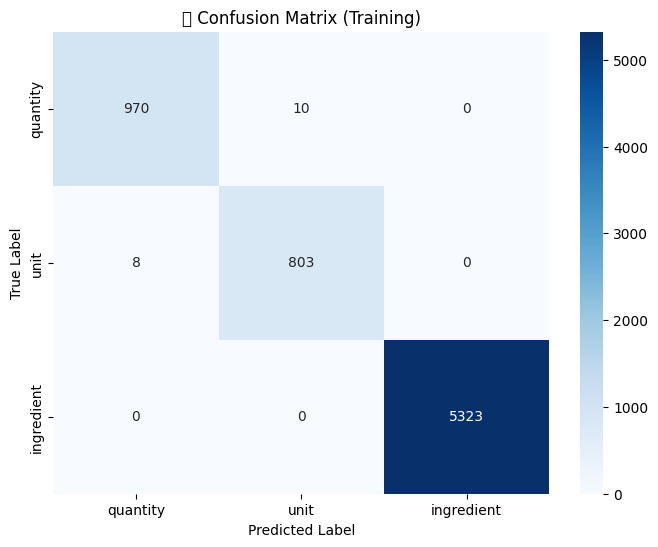

In [92]:
# create a confusion matrix on training datset
# Confusion Matrix (training)
cm = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("🔁 Confusion Matrix (Training)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [93]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf_model, "crf_model.pkl")

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [94]:
# predict the crf model on validation dataset
y_val_pred = crf_model.predict(X_val_weighted_features)

print("\n Sample Prediction on Validation Set:")
print("Tokens    :", X_val[0])
print("True Tags :", y_val_labels[0])
print("Predicted :", y_val_pred[0])


 Sample Prediction on Validation Set:
Tokens    : ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee', '1/2', 'teaspoon', 'Cardamom', 'Powder', 'Elaichi']
True Tags : ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']
Predicted : ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']


In [95]:
# specify flat classification report
# Flatten the nested lists
y_val_true_flat = [label for sent in y_val_labels for label in sent]
y_val_pred_flat = [label for sent in y_val_pred for label in sent]

# Use all labels seen by the model
labels = list(crf_model.classes_)
if 'O' in labels:  # Just in case
    labels.remove('O')

print("\n Flat Classification Report (Validation):")
print(metrics.flat_classification_report(
    y_val_labels, y_val_pred, labels=labels, digits=3
))


 Flat Classification Report (Validation):
              precision    recall  f1-score   support

    quantity      0.988     0.990     0.989       411
        unit      0.989     0.986     0.987       358
  ingredient      1.000     1.000     1.000      2107

    accuracy                          0.997      2876
   macro avg      0.992     0.992     0.992      2876
weighted avg      0.997     0.997     0.997      2876



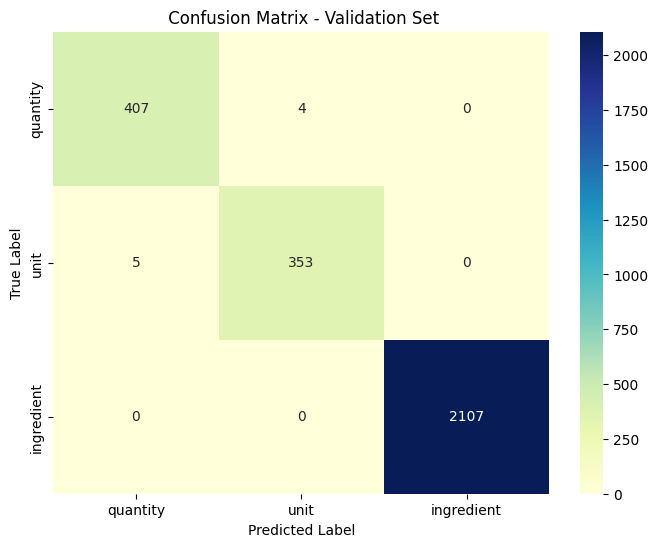

In [96]:
# create a confusion matrix on validation dataset
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)
plt.title(" Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [97]:
# flatten Labels and Initialise Error Data
# Flatten inputs, true labels, and predicted labels
val_tokens_flat = [token for sent in X_val for token in sent]
y_val_true_flat = [label for sent in y_val_labels for label in sent]
y_val_pred_flat = [label for sent in y_val_pred for label in sent]

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [98]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
# Initialize error data list
error_data = []

# Loop through all flattened tokens and labels
for i in range(len(val_tokens_flat)):
    true_label = y_val_true_flat[i]
    pred_label = y_val_pred_flat[i]
    token = val_tokens_flat[i]

    if true_label != pred_label:
        error_data.append({
            "token": token,
            "true_label": true_label,
            "predicted_label": pred_label,
            "index": i
        })

print(" Misclassified Tokens in Validation Set (Top 10):\n")
for error in error_data[:10]:
    print(f"Token: {error['token']:>15} | True: {error['true_label']:>10} | Predicted: {error['predicted_label']:>10}")

 Misclassified Tokens in Validation Set (Top 10):

Token:            cold | True:       unit | Predicted:   quantity
Token:           1-1/2 | True:   quantity | Predicted:       unit
Token:               2 | True:   quantity | Predicted:       unit
Token:               4 | True:   quantity | Predicted:       unit
Token:           pinch | True:       unit | Predicted:   quantity
Token:     tablespoons | True:       unit | Predicted:   quantity
Token:           pinch | True:       unit | Predicted:   quantity
Token:               a | True:       unit | Predicted:   quantity
Token:           pinch | True:   quantity | Predicted:       unit


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [99]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)
print("\n Total misclassifications:", len(error_df))
error_df.head()


 Total misclassifications: 9


,token,true_label,predicted_label,index
0,cold,unit,quantity,1028
1,1-1/2,quantity,unit,1030
2,2,quantity,unit,1252
3,4,quantity,unit,1597
4,pinch,unit,quantity,1603


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context



### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.